In [4]:
from rdkit import Chem
import numpy as np

import os
import glob

def get_com_sdf(sdf_file):
    coords = []
    with Chem.SDMolSupplier(sdf_file) as supp:
        for mol in supp:
            for i, atom in enumerate(mol.GetAtoms()):
                positions = mol.GetConformer().GetAtomPosition(i)
                # print(atom.GetSymbol(), positions.x, positions.y, positions.z)
                coords.append([positions.x, positions.y, positions.z])
        
            break
    coords = np.array(coords)
    return np.mean(coords, axis=0)

def get_com_mol2(mol2_file):
    with open(mol2_file) as f:
        lines = f.readlines()
        record = False
        coords = []
        for line in lines:
            if line.startswith("@<TRIPOS>ATOM"):
                record = True
                continue
            if line.startswith("@<TRIPOS>BOND"):
                record = False
                break
            if record:
                info = line.strip().split()
                x, y, z = info[2:5]
                coords.append([float(x), float(y), float(z)])
    coords = np.array(coords)
    return np.mean(coords, axis=0)

print(get_com_sdf("results/alphaflow_0/ligand_71/rank2_confidence-2.37.sdf"))
print(get_com_mol2("kalasanty_results/af2_active/pocket1.mol2"))

[ 8.03194848  3.05638788 -9.345     ]
[ 7.98865148 -1.46808884 -8.93965604]


In [ ]:
def pose_validate(pose_file:str, pocket_reference: str, distance_threshold: float=15):
    if pocket_reference.endswith(".mol2"):
        ref_coord = get_com_mol2(pocket_reference)
    elif pocket_reference.endswith(".sdf"):
        ref_coord = get_com_sdf(pocket_reference)
    lig_coord = get_com_sdf(pose_file)
    dist = np.linalg.norm(ref_coord - lig_coord)
    
    return dist < distance_threshold
    

In [14]:
pocket_data = [
    ("results/alphaflow_0", "kalasanty_results/alphaflow0/pocket1.mol2"),
    ("results/alphaflow_1", "results/alphaflow_1/ligand_47/minimized.sdf"),
    ("results/alphaflow_2", "kalasanty_results/alphaflow2/pocket1.mol2"),
    ("results/alphafold_gpcr", "kalasanty_results/af2_inactive/pocket1.mol2"),
    ("results/alphafold_gpcr_active_2", "kalasanty_results/af2_active/pocket1.mol2"),
    ("results/esmflow_0", "kalasanty_results/esmflow0/pocket1.mol2"),
    ("results/esmflow_1", "kalasanty_results/esmflow1/pocket0.mol2"),
    ("results/esmflow_2", "results/esmflow_2/ligand_80/minimized.sdf"),
    ("results/Q99705_model.active.crderr.pdb", "kalasanty_results/rosettafold_active/pocket0.mol2"),
    ("results/Q99705_model.inactive.crderr.pdb", "kalasanty_results/rosettafold_inactive/pocket0.mol2"),
]

rmsds = []
for res_dir, pocket_file in pocket_data:
    if pocket_file.endswith(".mol2"):
        ref_coord = get_com_mol2(pocket_file)
    elif pocket_file.endswith(".sdf"):
        ref_coord = get_com_sdf(pocket_file)
    
    pose_dirs = [d for d in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, d))] 
    pose_dirs = sorted(pose_dirs, key=lambda x: int(x.split("_")[-1]))
    for pose_dir in pose_dirs:
        pose_dir = os.path.join(res_dir, pose_dir)
        if not os.path.isdir(pose_dir):
            continue
        pose_files = glob.glob(os.path.join(pose_dir, "rank1.sdf"))
        pose_files = sorted(pose_files)
        
        for pose_f in pose_files:
            try:
                lig_coord = get_com_sdf(pose_f)
                rmsd = np.linalg.norm(ref_coord - lig_coord)
                rmsds.append(rmsd)
                if rmsd > 15:
                    print(f"Large rmsd in {pose_f}: {rmsd}")
                
            except Exception as e:
                print(f"Error in {pose_f}")
                continue
rmsds = np.array(rmsds)
    

[15:32:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Large rmsd in results/alphaflow_1/ligand_1/rank1.sdf: 31.686987924064063
Large rmsd in results/alphaflow_1/ligand_16/rank1.sdf: 31.95405612803261
Large rmsd in results/alphaflow_1/ligand_38/rank1.sdf: 29.552576246609274
Large rmsd in results/alphaflow_1/ligand_55/rank1.sdf: 34.14875894530759
Large rmsd in results/alphaflow_1/ligand_78/rank1.sdf: 33.61877020602758
Large rmsd in results/alphaflow_1/ligand_90/rank1.sdf: 33.35915110595483
Large rmsd in results/alphaflow_1/ligand_91/rank1.sdf: 25.027002891307678
Large rmsd in results/alphaflow_1/ligand_92/rank1.sdf: 33.74082562116517
Large rmsd in results/alphaflow_1/ligand_96/rank1.sdf: 34.39559683527744
Large rmsd in results/alphaflow_1/ligand_98/rank1.sdf: 34.802138633621404
Large rmsd in results/alphaflow_2/ligand_59/rank1.sdf: 39.67344544121607
Large rmsd in results/alphafold_gpcr/ligand_4/rank1.sdf: 30.530268583709642
Large rmsd in results/alphafold_gpcr/ligand_12/rank1.sdf: 28.85027119247533
Large rmsd in results/alphafold_gpcr/ligan

[15:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


0.20282235536845009
39.67344544121607


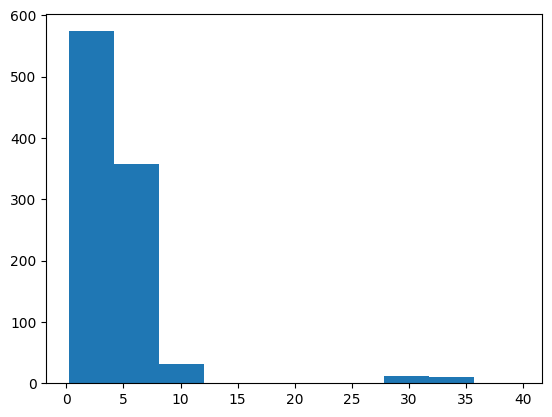

In [6]:
from matplotlib import pyplot as plt

rmsds1 = [rmsd for rmsd in rmsds]    
plt.hist(rmsds1)
print(min(rmsds1))
print(max(rmsds1))
plt.show()

In [11]:
rmsds > 5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False,  True,  True,  True, False,
        True, False, False, False,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True, False, False, False,
        True,  True,